In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp
from scipy import linalg as la

In [ ]:
def infinite_horizon(A,B,Q,R,tf,x0,labels,title=''):
    """solves the infinite horizon LQR problem. Defined as:
        x' = Ax + Bu
        J[u] = int_0^{\infty} (x^T Q x + u^T R u)dt

    Parameters:
        A ((n,n) ndarray): from the costate evolution equation
        B ((n,m) ndarray): from the costate evolution equation
        Q ((n,n) ndarray): from the cost functional
        R ((m,m) ndarray): from the cost functional
        tf (int): final time (for solving/plotting)
        x0 ((n,) ndarray): the initial position of the state
        labels ((n,) ndarray): the labels (strings) of the state elements
    """
    P = la.solve_continuous_are(A,B,Q,R)
    def infinite_evolve(t,y):
        return (A-B@la.inv(R)@B.T@P)@y

    #solve the optimal state evolution, and plot
    sol = solve_ivp(infinite_evolve,[0,tf],x0,dense_output=True)
    t = np.linspace(0,tf,101)
    solution = sol.sol(t)
    
    for i,x in enumerate(solution):
        plt.plot(t,x+beta[i],label=labels[i])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title(title)
    plt.show()

In [ ]:
def finite_horizon(A,B,Q,R,M,tf,x0,labels,title=''):
    """solves the finite horizon LQR problem. Defined as:
        x' = Ax + Bu
        J[u] = int_0^{tf} (x^T Q x + u^T R u)dt

    Parameters:
        A ((n,n) ndarray): from the costate evolution equation
        B ((n,m) ndarray): from the costate evolution equation
        Q ((n,n) ndarray): from the cost functional
        R ((m,m) ndarray): from the cost functional
        tf (int): final time
        x0 ((n,) ndarray): the initial position of the state
        labels ((n,) ndarray): the labels (strings) of the state elements
    """
    R_inv = la.inv(R)
    # solve the Riccati equation from homework 19.2
    def riccati(t,x):
        X = x[:4].reshape((2,2))
        Y = x[4:].reshape((2,2))
        dxdt = np.array([A@X+.5*B@R_inv@B.T@Y,2*Q@X-A.T@Y])
        return dxdt.reshape((8,))

    #Solve the Riccatti equation, and make sure to
    #save the output densely so we can interpolate later on
    xf = np.array([np.eye(2),-2*M]).reshape(-1)
    p_sol = solve_ivp(riccati,[tf,0],xf,dense_output=True)

    #Assuming that we have an ODE solution to the Riccatti
    #equation
    def finite_evolve(t,state):
        Z = p_sol.sol(t)
        X = Z[:4].reshape((2,2))
        Y = Z[4:].reshape((2,2))
        # P solves the ricatti equation
        P = -.5*Y @ la.inv(X)
        return A@state - (B@R_inv@B.T@P@state)

    #solve the optimal state evolution, and plot the state
    sol = solve_ivp(finite_evolve,[0,tf],x0,dense_output=True)
    t = np.linspace(0,tf,101)
    sol = sol.sol(t)
    for i,x in enumerate(sol):
        plt.plot(t,x+beta[i],label=labels[i])
    plt.xlabel('Time (Days)')
    plt.ylabel('Concentration')
    plt.title('Optimal State')
    plt.legend()
    plt.show()

    # solve for the state equation
    Z = p_sol.sol(t)

    u = []
    for i,step in enumerate(Z.T):
        X = step[:4].reshape((2,2))
        Y = step[4:].reshape((2,2))
        P = -.5*Y@np.linalg.inv(X)
        u.append(-R_inv@B.T@P@sol[:,i])
    u = np.array(u).T
    
    plt.plot(t,u[0])
    plt.plot(t,u[1])
    plt.legend(labels)
    plt.xlabel('Time (Days)')
    plt.ylabel('Concentration')
    plt.title('Optimal Control')
    plt.show()

In [ ]:
def oned_finite_horizon(A,B,Q,R,M,tf,x0,labels,title=''):
    """solves the finite horizon LQR problem. Defined as:
        x' = Ax + Bu
        J[u] = int_0^{tf} (x^T Q x + u^T R u)dt

    Parameters:
        A ((n,n) ndarray): from the costate evolution equation
        B ((n,m) ndarray): from the costate evolution equation
        Q ((n,n) ndarray): from the cost functional
        R ((m,m) ndarray): from the cost functional
        tf (int): final time
        x0 ((n,) ndarray): the initial position of the state
        labels ((n,) ndarray): the labels (strings) of the state elements
    """
    def riccati(t,x):
        dxdt = [A*x[0]+.5*B**2/R*x[1],2*Q*x[0]-A*x[1]]
        return dxdt
    
    xf = [1,-2*M]
    p_sol = solve_ivp(riccati,[tf,0],xf,dense_output=True)

    def evolve(t,x,p_sol):
        X,Y = p_sol.sol(t)
        P = -.5*Y/X
        return (A-B**2*P/R)*x

    final_sol = solve_ivp(evolve,[0,tf],np.array([x0]),args=[p_sol], dense_output=True)
    t = np.linspace(0,tf,101)
    x = final_sol.sol(t)
    X,Y = p_sol.sol(t)
    # solve for the control
    P = -.5*Y/X
    u = -B*P*x/R

    # plots
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.plot(t,np.squeeze(x)+beta, 'b',label = "Estrogen")
    plt.title('Optimal State')
    plt.xlabel('Time (Days)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.subplot(122)
    plt.plot(t,np.squeeze(u), 'b', label = "Estradiol")
    plt.title('Optimal Control')
    plt.xlabel('Time (Days)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.savefig()
    plt.show()
    

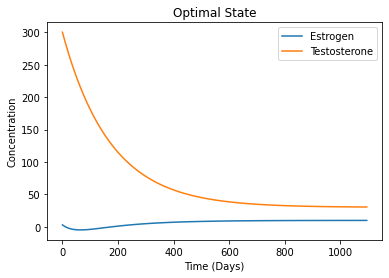

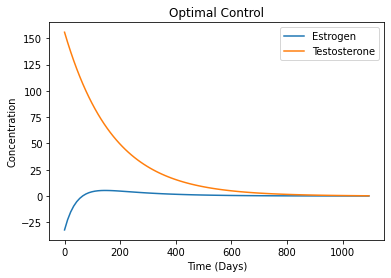

In [ ]:
A = np.array([[0,0],[0,0]])
B = np.array([[.01,0],[-.001,-.01]])
Q = np.array([[1,0],[0,1.]])
R = np.array([[.2,0],[0,3]])
M = 100*np.eye(2)
x0 = np.array([3-10,300-30])
beta = [10,30]
finite_horizon(A,B,Q,R,M,3*365,x0,labels=['Estrogen','Testosterone'])

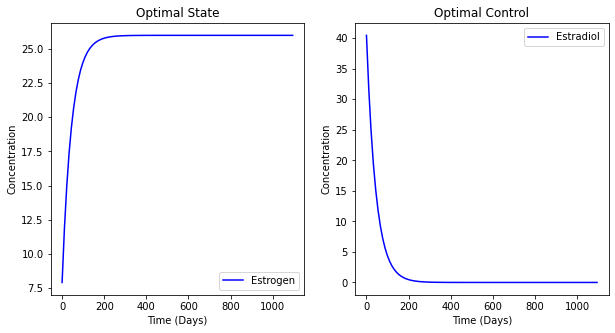

In [ ]:
# ANNIKA, THIS IS WHERE I RUN THE ONE-D CASE
alpha = 7.9     # starting condition
beta = 26       # ending condtion
a = 1e-7
b = 0.01
m = 10
q = 1
r = 0.2
x0 = alpha-beta
# WHY DO THEY LOOK THE SAME :(
oned_finite_horizon(a,b,q,r,m,3*365,x0,labels=None)

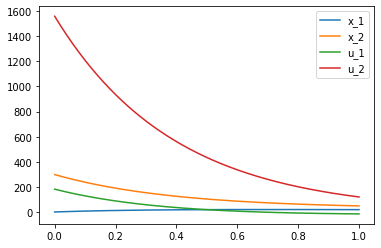

In [ ]:
def free_final_time_2d(A,B,Q,R,R_inv,M,x0,beta,dim):
    """solves the finite horizon LQR problem, optimizing over tf. Defined as:
        x' = Ax + Bu
        J[u] = int_0^{tf} (x^T Q x + u^T R u)dt

    Parameters:
        A ((n,n) ndarray): from the costate evolution equation
        B ((n,m) ndarray): from the costate evolution equation
        Q ((n,n) ndarray): from the cost functional
        R ((m,m) ndarray): from the cost functional
        tf (int): final time
        x0 ((n,) ndarray): the initial position of the state
        labels ((n,) ndarray): the labels (strings) of the state elements
    """   
    def ode(t,arr,p):
        deriv = []
        # iterate through time to solve for the state and costate from Theorem 19.1.2
        for i in range(arr.shape[1]):
            step = arr[:,i]
            # state is the last dim elements of arr at time step
            x_step = step[-dim:]
            # costate is the first len(step)-dim, reshaped to be square
            P_step = step[:-dim].reshape((dim,dim))
            u_step = -R_inv@B.T@P_step@x_step
            P_p = (-Q - A.T@P_step - P_step@A + P_step@B@R_inv@B.T@P_step).reshape((4,1))
            x_p = (A@x_step + B@u_step).reshape((2,1))
            deriv.append(np.vstack((P_p,x_p)))

        deriv = np.array(deriv).T
        #p[0] to find optimal time, reshape solutions to be one-d array
        return p[0]*deriv.reshape(6,arr.shape[1])

    def bc(arr_a,arr_b,p):
        x_a = arr_a[-dim:]
        P_a = arr_a[:-dim].reshape((dim,dim))

        x_b = arr_b[-dim:]
        P_b = arr_b[:-dim].reshape((dim,dim))

        p_b = -2*P_b@x_b
        u_b = -R_inv@B.T@P_b@x_b
        # H(t_f) = 0 because optimizing over final time
        H = p_b@A@x_b + p_b@B@u_b - x_b@Q@x_b - u_b@R@u_b
        # P(t_f) = M from Theorem 19.1.2,  H(t_f) = 0, x(0) = x0, our initial condition
        return np.hstack(((P_b-M).ravel(), H.ravel(), (x_a-x0).ravel()))

    t_steps = 200
    t = np.linspace(0,1,t_steps)
    y0 = np.ones((6,t_steps))
    p0 = np.array([900.])
    # solve bvp
    sol = solve_bvp(ode,bc,t,y0,p0,max_nodes=30000)
    
    # solve for state and u, iterating through time, from Theorem 19.1.2
    xs = []
    us = []
    Ps = []
    for i in range(t_steps):
        x_step = sol.y[:,i][-dim:]
        P_step = sol.y[:,i][:-dim].reshape((dim,dim))
        xs.append(x_step)
        Ps.append(P_step)
        us.append(-R_inv@B.T@P_step@x_step)
    
    # convert to arrays
    xs = np.array(xs)
    us = np.array(us)
    Ps = np.array(Ps)
    
    # plot
    plt.plot(t,xs[:,0]+beta[0],label='x_1')
    plt.plot(t,xs[:,1]+beta[1],label='x_2')
    plt.plot(t,us[:,0],label='u_1')
    plt.plot(t,us[:,1],label='u_2')
    plt.legend()
    plt.show()
    
    # optimal final time
    return sol.p[0]

In [ ]:
A = np.array([[0,0],[0,0]])
B = np.array([[.01,0],[-.0001,-.01]])
Q = np.array([[1,0],[0,100.]])
R = np.array([[.2,0],[0,3]])
R_inv = np.linalg.inv(R)
M = 100*np.eye(2)
x0 = np.array([3-10,300-30])
beta = [10,30]
dim = 2
free_final_time_2d(A,B,Q,R,R_inv,M,x0,beta,dim)

132.37439107288915

In [ ]:
A = np.array([[0,0],[0,0]])
B = np.array([[.01,0],[0,-.01]])
Q = np.array([[1,0],[0,1.]])
R = np.array([[.2,0],[0,3]])
M = 100*np.eye(2)
x0 = np.array([3-10,300-30])
beta = [10,30]
# to make the infinite horizon case work we need to switch to a solve_bvp and give an endpoint condition of 0 (or unshift the beta)
infinite_horizon(A,B,Q,R,M,3*365,x0,labels=['Estrogen','Testosterone'],title='Infinite Horizon')

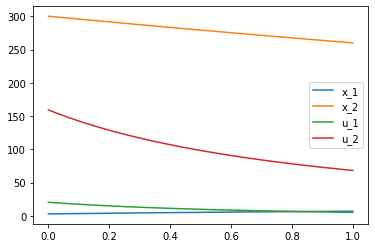

3913.159606391473


In [ ]:
A = np.array([[0,0],[0,0]])
B = np.array([[.01,0],[-.0001,-.01]])
Q = lambda t: (1+t)*np.array([[1,0],[0,1.]])
R = lambda t: (1+t)*np.array([[.2,0],[0,3]])
R_inv = lambda t: (1/(t+1))*np.array([[1/.2,0],[0,1/3]])
M = 100*np.eye(2)
x0 = np.array([3-10,300-30])
beta = [10,30]
dim = 2

def ode(t,arr,p):
    deriv = []
    for i,t_ in enumerate(t):
        step = arr[:,i]
        x_step = step[-dim:]
        P_step = step[:-dim].reshape((dim,dim))
        u_step = -R_inv(t_)@B.T@P_step@x_step
        P_p = (-Q(t_) - A.T@P_step - P_step@A + P_step@B@R_inv(t_)@B.T@P_step).reshape((4,1))
        x_p = (A@x_step + B@u_step).reshape((2,1))
        deriv.append(np.vstack((P_p,x_p)))

    deriv = np.array(deriv).T

    # arr = [P_11,P_12,P_21,P_22,x1,x2]
    # P_p = (-Q - A.T@P - P@A + P@B@R_inv@B.T@P).reshape((4,arr.shape[1]))
    # x_p = (A@x + B@u).reshape((2,arr.shape[1]))
    return p[0]*deriv.reshape(6,arr.shape[1])

def bc(arr_a,arr_b,p):
    x_a = arr_a[-dim:]
    P_a = arr_a[:-dim].reshape((dim,dim))
    
    x_b = arr_b[-dim:]
    P_b = arr_b[:-dim].reshape((dim,dim))

    p_b = -2*P_b@x_b
    u_b = -R_inv(t[-1])@B.T@P_b@x_b
    H = p_b@A@x_b + p_b@B@u_b - x_b@Q(t[-1])@x_b - u_b@R(t[-1])@u_b
    return np.hstack(((P_b-M).ravel(), H.ravel(), (x_a-x0).ravel()))

t_steps = 200
t = np.linspace(0,1,t_steps)
y0 = np.ones((6,t_steps))
p0 = np.array([10.])
sol = solve_bvp(ode,bc,t,y0,p0,max_nodes=30000)

xs = []
us = []
Ps = []
for i in range(t_steps):
    x_step = sol.y[:,i][-dim:]
    P_step = sol.y[:,i][:-dim].reshape((dim,dim))
    xs.append(x_step)
    Ps.append(P_step)
    us.append(-R_inv(t[i])@B.T@P_step@x_step)
    
xs = np.array(xs)
us = np.array(us)
Ps = np.array(Ps)

plt.plot(t,xs[:,0]+beta[0],label='x_1')
plt.plot(t,xs[:,1]+beta[1],label='x_2')
plt.plot(t,us[:,0],label='u_1')
plt.plot(t,us[:,1],label='u_2')
plt.legend()
plt.show()
print(sol.p[0])

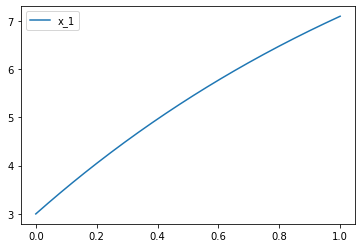

3913.159606391473


In [ ]:
plt.plot(t,xs[:,0]+beta[0],label='x_1')
#plt.plot(t,xs[:,1]+beta[1],label='x_2')
#plt.plot(t,us[:,0],label='u_1')
#plt.plot(t,us[:,1],label='u_2')
plt.legend()
plt.show()
print(sol.p[0])

In [ ]:
## initialize values
alpha = 7.9     # starting condition
beta = 26       # ending condtion
a = 1e-7
b = 0.01
m = 10
q = 1
r = 0.2
x0 = alpha-beta

p0 = [900.]
y0 = np.ones((2,200))

def oned_finite_free(a,b,q,r,m,p0,y0,x0):
    #time space
    t_steps = 200
    t = np.linspace(0,1,t_steps)

    def ode(t,y,p):
      u = b*y[1]/(2*r) #to replace with p since x' depends on u
      return p[0] * np.array([a*y[0]+b*u, -(a*y[1]-2*q*y[0])]) #multiply by time 


    def bc(ya,yb,p):
      ub = yb[1]*b/(2*r) #to replace u in terms of p
      ua = ya[1]*b/(2*r)

      return np.array([ya[0] - x0, yb[1] + 2*m*yb[0], yb[1]*(a*yb[0]+ub*b) + r*ub**2]) #have to optimize overr final time as well


    sol = solve_bvp(ode,bc,t,y0,p0,max_nodes=30000) #solve

# plots

    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.plot((sol.y[0]+beta)[:1162], 'r',label = "Estrogen")
    plt.title('Optimal State')
    plt.xlabel('Time (Days)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.subplot(122)
    plt.plot((sol.y[1]*b/(2*r))[:1162], 'r', label = "Estradiol")
    plt.title('Optimal Control')
    plt.xlabel('Time (Days)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.show()


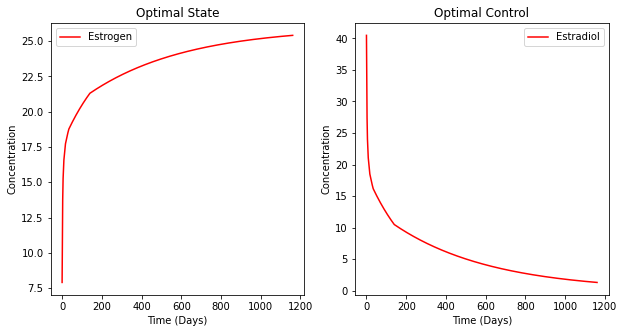

In [ ]:
oned_finite_free(a,b,q,r,m,p0,y0,x0)